In [5]:
import numpy as np
from gpu_xray_scattering import XS
from gpu_xray_scattering.Molecule import *
import glob
import MDAnalysis as mda
from MDAnalysis.topology.guessers import guess_types
from scipy.ndimage import binary_erosion, binary_dilation
import numpy.polynomial.polynomial as poly
import time
import matplotlib.pyplot as plt

def readPDB(fname, sel='protein', sel2=None, psf=None):

    
    if psf is not None:
        U = mda.Universe(psf, fname)
    else:
        U = mda.Universe(fname)
        
    # Get radius
    temp = PDB(fname)
    t0 = time.time()
    temp.lookup_unique_volume()
    temp.unique_radius = sphere_radius_from_volume(temp.unique_volume)
    # temp.scale_radii()
    temp.radius = temp.unique_radius
    t1 = time.time()
    print(f'Calculating unique volume took {t1-t0:.2f} s')
    unique_radius = temp.radius
    
    Usel = U.select_atoms(sel)
    
    try:
        print(Uele[:3])
        Uele = Usel.elements
    except:
        guessed_elements = guess_types(U.atoms.names)
        U.add_TopologyAttr('elements', guessed_elements)
    
    if sel2 is not None:
        Usel2 = U.select_atoms(sel2)
        return Usel.positions, Usel.elements, unique_radius[Usel.indices], \
               Usel2.positions, Usel2.elements, unique_radius[Usel2.indices]
    else:
        return Usel.positions, Usel.elements, unique_radius[Usel.indices], temp


In [6]:
# pro_coord1, pro_ele1, pro_radius1, pro_coord2, pro_ele2, pro_radius2 = readPDB('data/1U19_FH/1u19_rhodo_FH.pdb', sel='protein and segid A', sel2='resname RET and segid A')
pro_coord, pro_ele, pro_radius, temp = readPDB('data/1U19_FH/1u19_protein_FH.pdb', sel='segid A')

Calculating unique volume took 0.01 s


In [7]:
temp.radii_sf

array([1.33418, 1.18354, 1.04985, 0.99345])

In [8]:
pro_radius

array([1.13805658, 1.27864579, 1.3257249 , ..., 0.82339453, 0.8232058 ,
       0.82285167])

In [9]:
[print(f'{x}: {pro_radius[pro_ele == x].mean()}') for x in np.unique(pro_ele)]

C: 1.3424982658289135
H: 0.8250761030761078
N: 1.1466432190929285
O: 1.3084722533324813
S: 1.628034183325866


[None, None, None, None, None]

In [10]:
[print(f'{x}: {pro_radius[pro_ele == x].std()}') for x in np.unique(pro_ele)]

C: 0.05993257820510534
H: 0.0181823555365243
N: 0.04765245862774419
O: 0.007204009232416448
S: 0.023004855344602768


[None, None, None, None, None]

(array([ 17.,  98., 149.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0., 234., 459., 819., 409.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,  65., 160.,  79.,  23.,  27.,
          0.,  41.,   0.,   0.,  26.,   0.,   0.,  68.,   0.,   0.,   0.,
          1.,   1.,   1.,   0.,  22.,  11.]),
 array([0.79235889, 0.79431761, 0.79627633, 0.79823506, 0.80019378,
        0.80215251, 0.80411123, 0.80606995, 0.80802868, 0.8099874 ,
        0.81194613, 0.81390485, 0.81586357, 0.8178223 , 0.81978102,
        0.82173974, 0.82369847, 0.82565719, 0.82761592, 0.82957464,
        0.83153336, 0.83349209, 0.83545081, 0.83740954, 0.83936826,
        0.84132698, 0.84328571, 0.84524443, 0.84720315, 0.84916188,
        0.8511206 , 0.85307933, 0.85503805, 0.85699677, 0.8589555 ,
        0.86091422, 0.86287295, 0.86483167, 0.86679039, 0.86874912,
        0.87070784, 0.87266656, 0.87462529, 0.87658401, 0.87854274,
        0.88050146, 0.88246018, 0.88441891, 0.

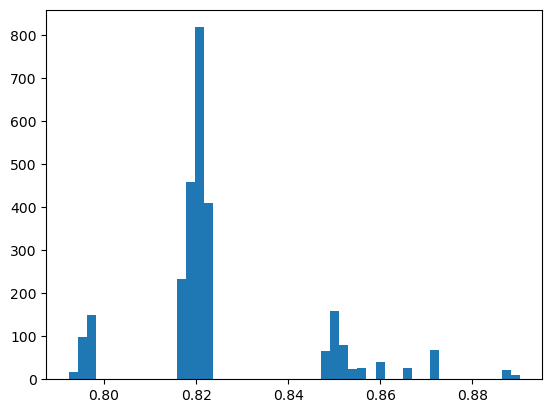

In [11]:
plt.hist(pro_radius[pro_ele == 'H'], bins=50)

In [12]:
print(pro_coord, pro_coord.shape)

[[ 53.284  -5.731  35.67 ]
 [ 52.214  -5.077  34.913]
 [ 52.674  -4.891  33.485]
 ...
 [  8.596  28.727 -10.977]
 [  9.781  27.851 -10.396]
 [  9.215  29.071  -9.561]] (5456, 3)


In [13]:
full = np.loadtxt('data/1U19_FH/1u19_rhodo_FH.pdb.dat')
full_v = np.loadtxt('data/1U19_FH/1u19_rhodo_FH_vacuo.pdb.dat')

In [14]:
denss = np.loadtxt('data/1U19_FH/1u19_holo_denss.dat').T
denss_v = np.loadtxt('data/1U19_FH/1u19_holo_denss_vacuo.dat').T

In [15]:
scatter = XS.Scatter(q=denss[:,0], use_oa=1)
scatter2 = XS.Scatter(q=denss[:,0], use_oa=0)

In [16]:
pro_all = Molecule(coordinates=pro_coord, elements=pro_ele)
pro_all.radius = pro_radius

In [17]:
canonical_radius = {'H': 1.07, 'C': 1.58, 'N': 0.84, 'O': 1.30, 'S':1.68}


In [18]:
for ele in canonical_radius.keys():
    pro_all.radius[pro_all.elements == ele] = canonical_radius[ele]

In [19]:
pro_all.radius[pro_all.elements == 'H']

array([1.07, 1.07, 1.07, ..., 1.07, 1.07, 1.07])

In [20]:
list(zip(pro_ele, pro_all.radius))[:10]

[('N', 0.84),
 ('C', 1.58),
 ('C', 1.58),
 ('O', 1.3),
 ('C', 1.58),
 ('C', 1.58),
 ('S', 1.68),
 ('C', 1.58),
 ('H', 1.07),
 ('H', 1.07)]

In [21]:
S_calc_soln = scatter.scatter(pro_all, rho=0.334, timing=True)
S_calc_vacuo = scatter.scatter(pro_all, rho=0.0, timing=True)

Elapsed time = 2424.457 ms
(156,)
Elapsed time = 13.528 ms
(156,)


In [22]:
S_calc2_soln = scatter2.scatter(pro_all, rho=0.334, timing=True)
S_calc2_vacuo = scatter2.scatter(pro_all, rho=0.0, timing=True)

Elapsed time = 41.981 ms
(156,)
Elapsed time = 41.971 ms
(156,)


In [23]:
0.49/0.334

1.467065868263473

Text(0.5, 1.0, "This implementation of soln exclusion matches that of FoXS's")

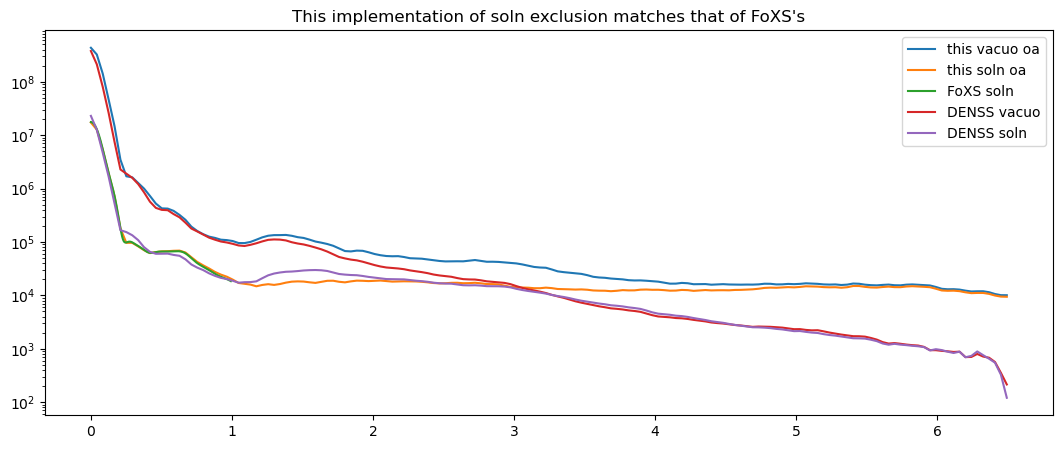

In [24]:
# plt.errorbar(scatter.q, S_calc_all, S_err)
plt.figure(figsize=(13, 5))
plt.plot(scatter.q, S_calc_vacuo, label='this vacuo oa')
plt.plot(scatter.q, S_calc_soln, label='this soln oa')
# plt.plot(scatter.q, S_calc2_vacuo, label='this vacuo')
# plt.plot(scatter.q, S_calc2_soln, label='this soln')
# plt.plot(scatter.q, S_calc_pro_before)
plt.plot(full[:, 0], full[:, 1], label='FoXS soln')
plt.plot(denss[:, 0], denss_v[:, 1], label='DENSS vacuo')
plt.plot(denss[:, 0], denss[:, 1], label='DENSS soln')
plt.yscale('log')
plt.legend()
plt.title('This implementation of soln exclusion matches that of FoXS\'s')

In [25]:
from scipy.optimize import minimize
import copy

In [26]:
# Now we need to determine our scaling factor
def inner_chi2(x, S_calc_soln, data, err):
    return np.sum((S_calc_soln - data * x[0]) / (err * x[0]))**2 / (len(data) - 1)

def modify_radii(this_mol, x):
    this_mol.radius[this_mol.elements == 'H'] = this_mol.radius[this_mol.elements == 'H'] * x[0]
    this_mol.radius[this_mol.elements == 'C'] = this_mol.radius[this_mol.elements == 'C'] * x[1]
    this_mol.radius[this_mol.elements == 'N'] = this_mol.radius[this_mol.elements == 'N'] * x[2]
    this_mol.radius[this_mol.elements == 'O'] = this_mol.radius[this_mol.elements == 'O'] * x[3]
    return this_mol

def calc_chi2(x, mol, scatter, data, err):
    # x is the scaling factors for 'H','C','N','O', in this order
    this_mol = copy.deepcopy(mol)
    this_mol = modify_radii(this_mol, x)
    S_calc_soln = scatter.scatter(this_mol, rho=0.334, timing=False)
    # print(S_calc_soln)
    res = minimize(inner_chi2, [1], args=(S_calc_soln, data, err))
    # print(res)
    chi2 = np.sum(((S_calc_soln - data * res.x) / (err * res.x))**2) / (len(data) - 1)
    print(x, res.x, chi2)
    return chi2

In [27]:
pro_coord, pro_ele, pro_radius, temp = readPDB('data/6LYZ/6lyz_h.pdb', sel='protein')

Calculating unique volume took 0.00 s


In [28]:
pro_radius

array([1.13612082, 1.28042654, 1.32687633, ..., 0.82213421, 0.82213421,
       0.82213421])

In [29]:
pro_all = Molecule(coordinates=pro_coord, elements=pro_ele, radius=pro_radius.copy())
pro_all_foxs = Molecule(coordinates=pro_coord, elements=pro_ele, radius=pro_radius.copy())

In [30]:
for ele in canonical_radius.keys():
    pro_all_foxs.radius[pro_all_foxs.elements == ele] = canonical_radius[ele]

In [31]:
pro_radius

array([1.13612082, 1.28042654, 1.32687633, ..., 0.82213421, 0.82213421,
       0.82213421])

In [32]:
lyz_expt = np.loadtxt('data/6LYZ/SASDCK8.dat', skiprows=3, max_rows=1914)

In [33]:
lyz_expt[:, 0] = lyz_expt[:, 0] / 10

In [34]:
scatter = XS.Scatter(q=lyz_expt[:,0], use_oa=1)

In [35]:
S_calc_soln = scatter.scatter(pro_all, rho=0.334, timing=True)
S_calc_soln_foxs = scatter.scatter(pro_all_foxs, rho=0.334, timing=True)

Elapsed time = 169.699 ms
(1914,)
Elapsed time = 109.937 ms
(1914,)


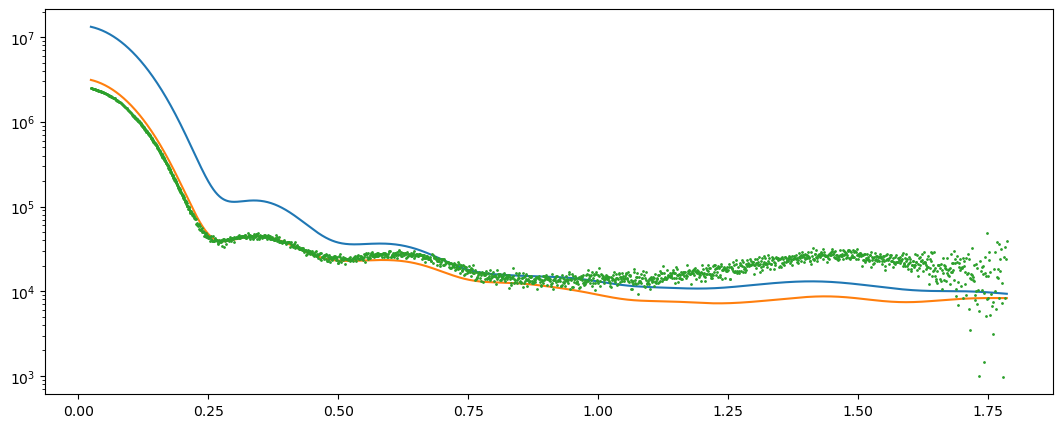

In [37]:
plt.figure(figsize=(13, 5))
plt.plot(lyz_expt[:, 0], S_calc_soln)
plt.plot(lyz_expt[:, 0], S_calc_soln_foxs)
plt.plot(lyz_expt[:, 0], lyz_expt[:, 1]*4000, '.', markersize=2)
plt.yscale('log')

In [38]:
res = minimize(calc_chi2, [1, 1, 1, 1, 2000], args=(pro_all, scatter, lyz_expt[:, 1], lyz_expt[:, 2]), method="Nelder-Mead", bounds=[(0.8, 1.4)]*4 + [(100, None)])

(1914,)
[1.e+00 1.e+00 1.e+00 1.e+00 2.e+03] [16967.85850411] 383.3125808930623
(1914,)
[1.05e+00 1.00e+00 1.00e+00 1.00e+00 2.00e+03] [15951.09927187] 371.3642687753036
(1914,)
[1.00e+00 1.05e+00 1.00e+00 1.00e+00 2.00e+03] [14094.06675292] 368.47081716164035
(1914,)
[1.00e+00 1.00e+00 1.05e+00 1.00e+00 2.00e+03] [16396.46692446] 384.61583783805435
(1914,)
[1.00e+00 1.00e+00 1.00e+00 1.05e+00 2.00e+03] [16162.80938831] 383.1151211505242
(1914,)
[1.0e+00 1.0e+00 1.0e+00 1.0e+00 2.1e+03] [16967.85850411] 383.3125808930623
(1914,)
[1.02e+00 1.02e+00 9.50e-01 1.02e+00 2.04e+03] [15631.58752017] 371.8867702324391
(1914,)
[1.028e+00 1.028e+00 9.800e-01 1.028e+00 1.916e+03] [14609.38637628] 368.13273650459394
(1914,)
[1.042e+00 1.042e+00 9.700e-01 1.042e+00 1.824e+03] [13446.57237953] 358.86192956923327
(1914,)
[1.0448e+00 1.0448e+00 9.6800e-01 1.0448e+00 1.9456e+03] [13215.84096973] 356.84658672863617
(1914,)
[1.0672e+00 1.0672e+00 9.5200e-01 1.0672e+00 1.9184e+03] [11397.76442774] 338.4277

In [39]:
res

 final_simplex: (array([[1.14133403e+00, 1.21039000e+00, 8.00000000e-01, 1.38214259e+00,
        1.70319288e+03],
       [1.14133403e+00, 1.21039000e+00, 8.00000000e-01, 1.38214259e+00,
        1.70319284e+03],
       [1.14133403e+00, 1.21039000e+00, 8.00000000e-01, 1.38214259e+00,
        1.70319280e+03],
       [1.14133403e+00, 1.21039000e+00, 8.00000000e-01, 1.38214258e+00,
        1.70319289e+03],
       [1.14133404e+00, 1.21038999e+00, 8.00000000e-01, 1.38214258e+00,
        1.70319289e+03],
       [1.14133403e+00, 1.21039000e+00, 8.00000000e-01, 1.38214259e+00,
        1.70319285e+03]]), array([7.85005075, 7.8500508 , 7.85005096, 7.85005142, 7.8500517 ,
       7.85005183]))
           fun: 7.8500507505689106
       message: 'Optimization terminated successfully.'
          nfev: 607
           nit: 340
        status: 0
       success: True
             x: array([1.14133403e+00, 1.21039000e+00, 8.00000000e-01, 1.38214259e+00,
       1.70319288e+03])

In [40]:
pro_final = copy.deepcopy(pro_all)
pro_final = modify_radii(pro_final, res.x)
S_calc_soln_final = scatter.scatter(pro_final, rho=0.334, timing=True)

Elapsed time = 182.521 ms
(1914,)


In [41]:
res.x[4]

1703.19287609928

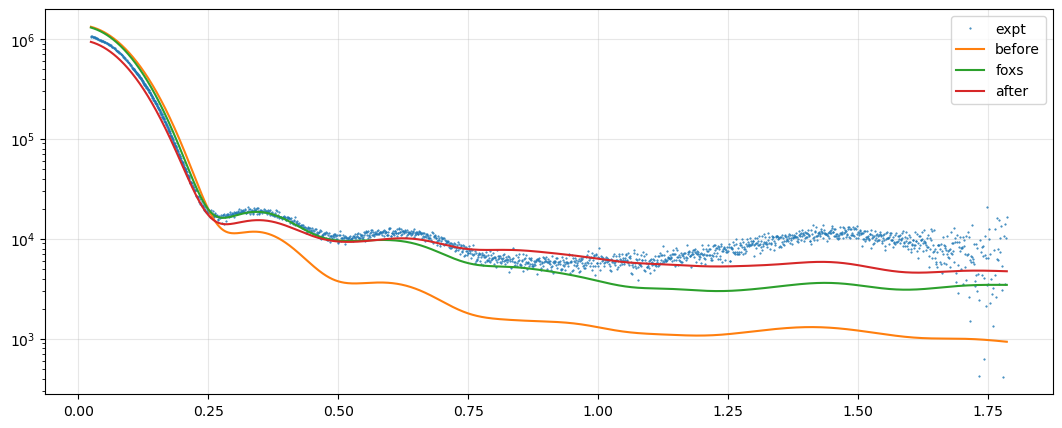

In [54]:
plt.figure(figsize=(13, 5))
plt.grid(alpha=0.3)
plt.plot(lyz_expt[:, 0], lyz_expt[:, 1]*res.x[4], '.', markersize=1, label='expt')
plt.plot(lyz_expt[:, 0], S_calc_soln/10, label='before')
plt.plot(lyz_expt[:, 0], S_calc_soln_foxs/2.4, label='foxs')
plt.plot(lyz_expt[:, 0], S_calc_soln_final, label='after')
plt.yscale('log')
plt.legend()

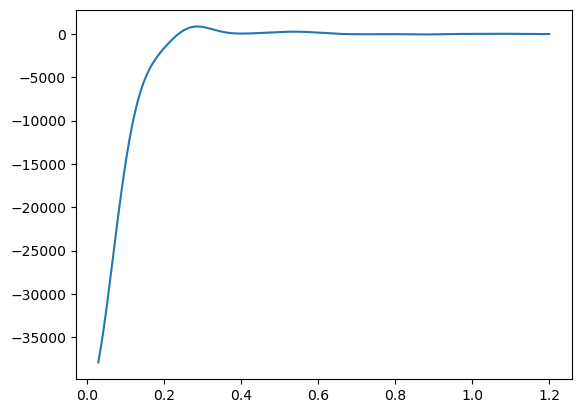

In [30]:
plt.plot(scatter.q, S_calc_all - S_calc_pro_before)
# plt.errorbar(scatter.q, S_calc_all - S_calc_pro_before, S_err)

In [312]:
# Solve for the scaling factor for trial density

def res_func_analytical(Idata, Iprior, Icross, Iguess, sigqdata):
    a = np.sum(2 * Icross * (Idata - Iprior) / sigqdata**2) # zeroth order term
    b = np.sum(-(4 * Icross**2 - 2 * Iguess * (Idata - Iprior)) / sigqdata**2)
    c = np.sum(-6 * Iguess * Icross / sigqdata**2)
    d = np.sum(-2 * Iguess**2 / sigqdata**2)
    eq = poly.Polynomial((a, b, c, d))
    roots = eq.roots()
#     print(f'analytical roots: {roots}')
    chi = np.inf
    root_best = 0
    for root_c in roots[np.isreal(roots)]:
        root = root_c.real
        chi_this = np.sum(((Idata - Iprior - Icross * 2 * root - Iguess * root * root) / sigqdata)**2)/Idata.size
        if chi_this < chi:
            chi = chi_this
            root_best = root
#     print(f'analytical gives {chi} at {root_best}')
    return root_best
# Add to weight
# Flatten negative weight

In [313]:
import time
from scipy import ndimage
def refine(xyz, trial_list, op, S_calc_all, S_err, scatter, pro,
           steps=10000,
           timing_step=500,
           flatten_step=100,
           connectivity_step=1000,
           weight_max=0.05,
           struct_connectivity_A=4,
           grid_spacing=0.75,
           start_refine=5000,
           rho=0.334,
           do_trial=True,
           write_traj=None,
           write_fname=None,
           input_weight=None,
           enforce_positivity=True):
    
    n_origins = len(trial_list)
    if input_weight is None:
        weight = np.random.random(len(xyz))
        weight[~op.flatten()] = 0
        S_calc_pro, S_calc_trial, S_calc_cross = \
                scatter.cross_scatter(pro, prior=np.empty((0, 3)), weight_p=np.empty(0), 
                                      trial=xyz[op.flatten()], weight_t=weight[op.flatten()], 
                                      rho=rho, timing=True)
        S_calc_pro_before = S_calc_pro.copy() # Initial curve

        chi_zero = (((S_calc_all - S_calc_pro) / S_err)**2).sum() / (len(S_calc_all) - 1)
        chi_before = (((S_calc_all - S_calc_pro - S_calc_trial - 2 * S_calc_cross) / S_err)**2).sum() / (len(S_calc_all) - 1)
        scaling = res_func_analytical(S_calc_all, S_calc_pro, S_calc_cross, S_calc_trial, S_err)
        print(f'Initial scaling: {scaling:.3f}')
        weight[op.flatten()] *= scaling
        weight_trial = weight.copy()
        S_calc_pro, _, _ = \
                scatter.cross_scatter(pro, prior=xyz, weight_p=weight, 
                                      trial=xyz, rho=rho, timing=True)
        chi_after = (((S_calc_all - S_calc_pro) / S_err)**2).sum() / (len(S_calc_all) - 1)
        print(chi_zero, chi_before, chi_after, (weight>0).sum())
    else:
        weight = input_weight
        
    chi_trace = []
    scale_trace = []
    fine_timing_trace = []


    timing_step = timing_step
    flatten_step = flatten_step
    connectivity_step = connectivity_step
    weight_max = weight_max
    struct_connectivity = int(struct_connectivity_A / spacing)
    start_refine = start_refine
    trial = do_trial
    write_traj = write_traj
    if trial:
        weight_trial = weight.copy()

    t0 = time.time()
    t01 = time.time()
    for idx in range(steps+1):

        choice = np.random.choice(np.arange(n_origins))
        if idx > start_refine:
            while (weight[trial_idx[choice]] > 0).sum() < len(trial_idx[choice]) / 2:
                # limit sampling to near existing density
                choice = np.random.choice(np.arange(n_origins))
        S_calc_pro, S_calc_trial, S_calc_cross = \
            scatter.cross_scatter(pro, prior=xyz[weight > 0], weight_p=weight[weight > 0], 
                                  trial=trial_list[choice], rho=rho, timing=False)
        chi_before = (((S_calc_all - S_calc_pro) / S_err)**2).sum() / (len(S_calc_all) - 1)
        scaling = res_func_analytical(S_calc_all, S_calc_pro, S_calc_cross, S_calc_trial, S_err)

        if trial:
            # Risk of increasing chi^2, so recalc 
            weight_trial[trial_idx[choice]] += scaling
            if enforce_positivity:
                weight_trial[weight_trial<0] = 0
            S_calc_pro, S_calc_trial, S_calc_cross = \
                scatter.cross_scatter(pro, prior=xyz[weight_trial > 0], weight_p=weight_trial[weight_trial > 0], 
                                      trial=trial_list[choice], rho=rho, timing=False)
            chi_after = (((S_calc_all - S_calc_pro) / S_err)**2).sum() / (len(S_calc_all) - 1)

            if chi_after < chi_before:
                weight = weight_trial.copy()
                scale_trace.append(scaling)
            else:
                weight_trial = weight.copy()
                scale_trace.append(np.nan)
            chi = min(chi_after, chi_before)
        else:
            chi = chi_before
            scale_trace.append(scaling)
            weight[trial_idx[choice]] += scaling
            if enforce_positivity:
                weight[weight<0] = 0

        chi_trace.append(chi)    

        if flatten_step is not None and idx > 0 and idx % flatten_step == 0:
            if enforce_positivity:
            # flatten
                weight[weight < weight.max() * weight_max] = 0
            else:
                weight[np.abs(weight) < np.abs(weight).max() * weight_max] = 0

        if connectivity_step is not None and idx > 0 and idx % connectivity_step == 0:
            
            
            # Pick largest feature
            struct = ndimage.generate_binary_structure(3, 2)
            labeled_support, num_features = ndimage.label(np.abs(weight).reshape(op.shape), structure=struct)
            labeled_support = labeled_support.flatten()
            sums = np.zeros((num_features))

            #find the feature with the greatest number of electrons
            for feature in range(num_features+1):
                sums[feature-1] = np.sum(np.abs(weight)[labeled_support==feature])
            big_feature = np.argmax(sums)+1

            #remove features from the support that are not the primary feature
            weight[labeled_support != big_feature] = 0
            print()
            print(f'Stray feature removal: Map has {num_features} blobs, removing {num_features-1} of them')
            print(f'Zeroed {sums.sum() - np.max(sums):.2f} carbon-equivalents, {np.max(sums):.2f} remaining')

            # Smooth
            weight = ndimage.gaussian_filter(weight, sigma=1)
            
        if write_traj is not None and idx > 0 and idx % write_traj == 0:
            if idx == write_traj:
                write_out(xyz, weight, 'traj.pdb', mode='w', save_space=False)
            else:
                write_out(xyz, weight, 'traj.pdb', mode='a', save_space=False)


        if timing_step is not None and idx > 0 and idx % timing_step == 0:
            t1 = time.time()
            if idx == timing_step:
                t2 = t0
            print(f'Timing step {idx}: {(t1 - t0):.2f}s ({(t1-t0)/idx*1000:.2f} ms/step | {idx/(t1-t0):.2f} steps/s | ', end='')
            print(f'this {timing_step} steps: {timing_step/(t1-t2):.2f} steps/s)')
            t2 = time.time()

        print(f'Step {idx:4d}: scaling = {scaling:.4e}, chi^2 = {chi:.4e}', end='\r')
        t00 = time.time()
        fine_timing_trace.append(t00 - t01)
        t01 = time.time()
    final_S_calc, _ , _ = \
            scatter.cross_scatter(pro, prior=xyz[weight_trial > 0], weight_p=weight_trial[weight_trial > 0], 
                                  trial=trial_list[choice], rho=rho, timing=False)
    return weight, chi_trace, scale_trace, fine_timing_trace, final_S_calc

In [314]:
weight_list = []
chi_list = []
for idx in range(1):
    print(f'\n\n### Run {idx} ###')
    weight, chi_trace, scale_trace, fine_timing_trace, final_S_calc = \
        refine(xyz, trial_list, allowed_points, S_calc_all, S_err, scatter, pro,
               grid_spacing=spacing, steps=5000, do_trial=True, rho=0.334,
               weight_max=0.05, enforce_positivity=True)#, input_weight=weight.copy())
    weight_list.append(weight)
    chi_list.append(chi_trace[-1])



### Run 0 ###
Elapsed time = 76.618 ms
Initial scaling: 0.012
Elapsed time = 143.596 ms
0.33559493870753065 75608.28913071688 0.07901533287901923 4613
Timing step 500: 18.15s (36.31 ms/step | 27.54 steps/s | this 500 steps: 27.54 steps/s)
Step  999: scaling = -9.6924e-03, chi^2 = 9.3824e-04
Stray feature removal: Map has 13 blobs, removing 12 of them
Zeroed 1.25 carbon-equivalents, 19.59 remaining
Timing step 1000: 36.25s (36.25 ms/step | 27.59 steps/s | this 500 steps: 27.63 steps/s)
Timing step 1500: 55.80s (37.20 ms/step | 26.88 steps/s | this 500 steps: 25.57 steps/s)
Step 1999: scaling = 2.9267e-04, chi^2 = 3.8720e-044
Stray feature removal: Map has 15 blobs, removing 14 of them
Zeroed 0.33 carbon-equivalents, 19.29 remaining
Timing step 2000: 75.78s (37.89 ms/step | 26.39 steps/s | this 500 steps: 25.03 steps/s)
Timing step 2500: 95.88s (38.35 ms/step | 26.07 steps/s | this 500 steps: 24.88 steps/s)
Step 2999: scaling = 6.4472e-04, chi^2 = 2.2894e-044
Stray feature removal: Map

In [315]:
weight_list = np.array(weight_list)

In [316]:
weight_list.mean(0).shape

(6528,)

In [324]:
for idx, w in enumerate(weight_list):
    write_out(xyz, w, f'run_ex{idx}p.pdb', save_neg=True)

In [318]:
# write_out(xyz, weight_list.mean(0), 'run_ex_average.pdb')

Text(0, 0.5, 'Timing (ms)')

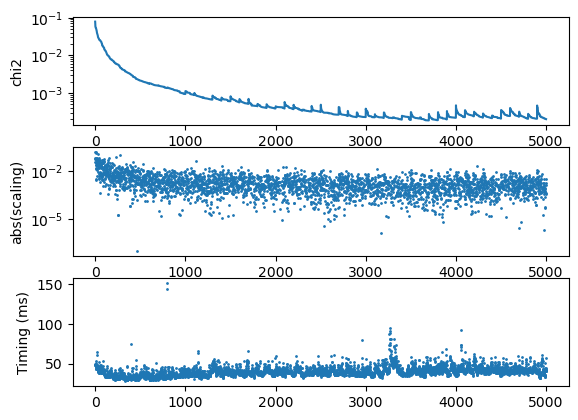

In [319]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, 1)
ax[0].plot(chi_trace)
ax[0].set_yscale('log')
ax[0].set_ylabel('chi2')
ax[1].plot(np.abs(scale_trace),'.', markersize=2)
ax[1].set_ylabel('abs(scaling)')
ax[1].set_yscale('log')
ax[2].plot(np.array(fine_timing_trace)*1000,'.', markersize=2)
ax[2].set_ylabel('Timing (ms)')


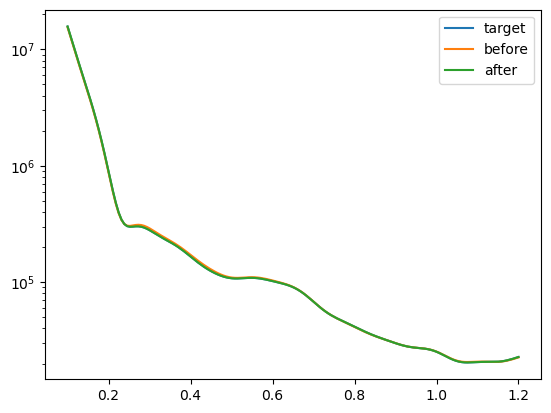

In [320]:

plt.plot(scatter.q, S_calc_all, label='target')
plt.yscale('log')
plt.plot(scatter.q, S_calc_pro_before, label='before')
plt.plot(scatter.q, final_S_calc, label='after')
# plt.plot(scatter.q, S_calc_trial, label='chain B')
# plt.plot(scatter.q, S_calc_cross, label='chain A x chain B')
# plt.plot(scatter.q, S_calc_pro + S_calc_trial + 2 * S_calc_cross, label='trial')
plt.legend()

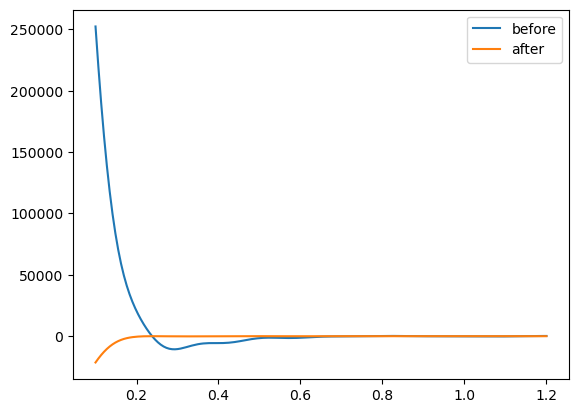

In [321]:
# plt.plot(scatter.q, S_calc_all, label='target')
# plt.yscale('log')
plt.plot(scatter.q, S_calc_all -S_calc_pro_before, label='before')
plt.plot(scatter.q, S_calc_all - final_S_calc, label='after')
# plt.plot(scatter.q, S_calc_trial, label='chain B')
# plt.plot(scatter.q, S_calc_cross, label='chain A x chain B')
# plt.plot(scatter.q, S_calc_pro + S_calc_trial + 2 * S_calc_cross, label='separate')
plt.legend()

In [322]:
# write_out(xyz, allowed_points.flatten(), 'test.pdb', grid='grid.pdb', op=allowed_points)

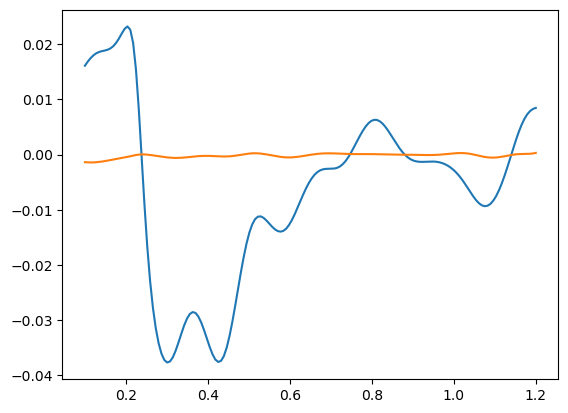

In [323]:
import matplotlib.pyplot as plt
plt.plot(scatter.q, (S_calc_all - S_calc_pro_before) / S_calc_all)
plt.plot(scatter.q, (S_calc_all - final_S_calc) / S_calc_all)